# University of Michigan, NA/EECS 568, ROB 530 
# Mobile Robotics: Methods & Algorithms, Winter 2026

## Solving Problems with Filtering
This notebook explores several fundamental filtering techniques used in robotics and state estimation:

1. Bayes Filter: A general probabilistic framework for recursive state estimation
   - Example: Estimating a robot's 1D position using discrete observations
   - Demonstrates belief updates using sensor measurements and motion models

2. Kalman Filter: Optimal estimator for linear systems with Gaussian noise
   - Example: Tracking a constant-velocity target with noisy position measurements
   - Shows how KF combines predictions and measurements optimally

3. Extended Kalman Filter: Nonlinear extension of the Kalman filter
   - Example: Robot localization with range-bearing measurements to landmarks
   - Illustrates linearization of nonlinear models and its effects

4. Particle Filter: Non-parametric approach using sample-based representations
   - Example: Global robot localization in a known map
   - Demonstrates particle resampling and handling of multi-modal beliefs

### Each section will include:
- Mathematical formulation
- Python implementation
- Visualization of results
- Discussion of strengths and limitations

### Prerequisites:
- Basic probability and statistics
- Linear algebra (matrices, vectors)
- Python programming
- NumPy, Matplotlib libraries

### Learning Objectives:
- Understand key probabilistic filtering algorithms
- Implement filters in Python
- Analyze filter performance and limitations
- Apply filters to toy and robotics problems

### References:
- Probabilistic Robotics (Thrun, Burgard, Fox)
- State Estimation for Robotics (Barfoot)
- Course lecture notes


# 1. Bayes Filter

The Bayes filter is a probabilistic framework for recursively estimating the state of a system from noisy measurements. In this section, we'll implement a simple 1D robot localization example using discrete Bayes filtering.

## Mathematical Formulation

The Bayes filter maintains a belief distribution over possible states and updates it in two steps:
1. Prediction step using motion model
2. Update step using measurement model

Prediction step (motion model):
- $bel^-_t(x_t) = \int p(x_t|u_t,x_{t-1})bel_{t-1}(x_{t-1})dx_{t-1}$

Update step (measurement model):
- $bel_t(x_t) = \eta p(z_t|x_t)bel^-_t(x_t)$

Notation:
- $x_t$: System state at time t
- $u_t$: Control input at time t
- $z_t$: Measurement at time t
- $bel_t(x_t)$: Posterior belief of state at time t
- $bel^-_t(x_t)$: Prior belief before measurement update
- $p(x_t|u_t,x_{t-1})$: State transition probability (motion model)
- $p(z_t|x_t)$: Measurement probability (sensor model)
- $\eta$: Normalization factor to ensure probabilities sum to 1


We'll demonstrate this by having a robot move in 1D and estimate its position using noisy sensor readings.


## Problem Statement:
A robot is moving in a 1D environment and needs to estimate its position using noisy sensor measurements.
The robot can move left or right by a specified number of cells, but its motion is uncertain - it may end up
±1 cell from the intended position. The robot also has a sensor that provides noisy position measurements
with Gaussian noise.

### Given:
- Environment: 1D grid with 10 cells (n_cells = 10)
- Motion model uncertainty: ±1 cell from intended position
  - P(correct position) = 0.4
  - P(±1 cell error) = 0.3 each
- Measurement model: Gaussian noise with σ = 1.0
- Initial belief: Uniform distribution across all cells (1/10 for each position)
- Control sequence (u): [2, 1, 0, 1, 2] cells
- Measurement sequence (z): [3, 4, 4, 5, 7] position readings
- Number of time steps: 5

### Wanted:
- Estimate the robot's position over time using Bayes filtering
- Track and update belief distribution as robot moves and takes measurements
- Demonstrate how combining motion and measurement updates improves position estimation



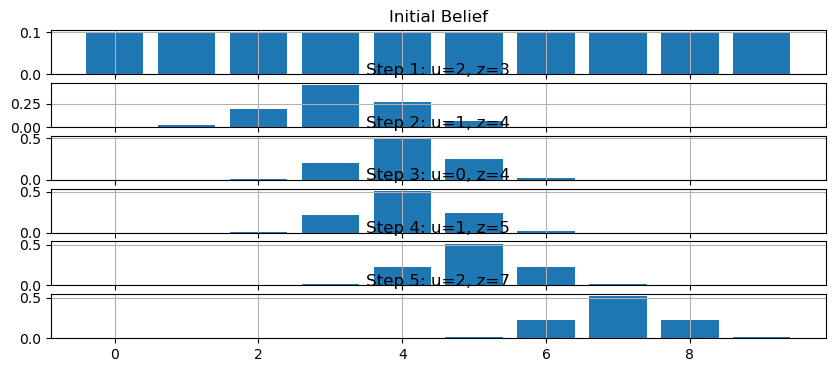

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def bayes_filter_1d(prior_belief, motion_model, measurement_model, control, measurement):
    """
    Implements one step of the Bayes filter.
    
    Args:
        prior_belief: Array of probabilities representing current belief state
        motion_model: Function that takes (x_prev, u) and returns p(x|u,x_prev)
        measurement_model: Function that takes (x, z) and returns p(z|x)
        control: Control input u
        measurement: Sensor measurement z
    
    Returns:
        posterior: Updated belief state after motion and measurement
    """
    # Prediction step
    prior = np.zeros_like(prior_belief)   #全0先验
    for i in range(len(prior_belief)):   #遍历
        for j in range(len(prior_belief)):
            prior[i] += motion_model(i, j, control) * prior_belief[j]   #求和：转移概率（已知control，从i到j的概率） * 之前时刻在位置j的belief
            
    # Update step
    posterior = measurement_model(np.arange(len(prior)), measurement) * prior    #用当前时刻观测 measurement：计算从prior到measurement的转移概率
    
    # Normalize
    posterior /= np.sum(posterior)  #归一化计算
    
    return posterior

# Example motion and measurement models
def simple_motion_model(x_curr, x_prev, u):
    """
    Simple motion model where robot tries to move by u cells.
    Returns probability of landing at x_curr given starting at x_prev.
    Includes noise where robot might end up ±1 cell from intended position.
    """
    intended_pos = x_prev + u    # 理想的位置=上一时刻的位置 + 走多少步
    if abs(x_curr - intended_pos) <= 1:  #当前位置的概率为0.3 0.4 0.3
        return 0.3 if x_curr != intended_pos else 0.4   
    return 0.0

def simple_measurement_model(x, z):
    """
    Simple measurement model where sensor reading has Gaussian noise.
    Returns probability of getting measurement z at position x.
    """
    sigma = 1.0
    return np.exp(-0.5 * ((x - z) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))   #已知x，z是均值为x，方差唯一的值

# Run filter for multiple steps to show evolution of belief
n_steps = 5    # 走五步骤
controls = [2, 1, 0, 1, 2]  # Sequence of controls 五次控制
measurements = [3, 4, 4, 5, 7]  # Sequence of measurements   五次观测 

n_cells = 10  # 10个单位
belief = np.ones(n_cells) / n_cells  # Initial uniform belief  均匀分布的先验

plt.figure(figsize=(10, 4))   
plt.subplot(n_steps + 1, 1, 1)
plt.bar(range(n_cells), belief)
plt.title('Initial Belief')
plt.grid(True)

for i in range(n_steps):
    belief = bayes_filter_1d(belief, simple_motion_model, simple_measurement_model,
                           controls[i], measurements[i])    #每得到一个观测，更新一次belief
    
    plt.subplot(n_steps + 1, 1, i + 2)
    plt.bar(range(n_cells), belief)
    plt.title(f'Step {i+1}: u={controls[i]}, z={measurements[i]}')
    plt.grid(True)

plt.show()

#图中可以清晰看到机器人可能存在的位置
#缺点：需要精确的所有模型，计算量巨大，适用于离散情况而非连续。


# Discussion: Strengths and Limitations of Bayes Filter

## Strengths:
- Probabilistic approach that handles uncertainty in both motion and sensing
- Can represent arbitrary probability distributions over the state space
- Mathematically principled way to fuse predictions with measurements
- Works well for discrete state spaces with non-linear models
- Can handle multi-modal distributions (multiple hypotheses)

## Limitations:
- Computational complexity grows exponentially with state space dimensionality
- Requires accurate motion and measurement models
- Discrete approximation may lose precision compared to continuous distributions
- Memory intensive for large state spaces
- May require many grid cells for good accuracy
- Cannot easily handle continuous state spaces without discretization

## When to Use:
- Good for low-dimensional state estimation problems
- Useful when probability distributions are complex/non-Gaussian
- Appropriate when discrete state representation is natural
- When computational resources allow for fine grid resolution



# 2. Mathematical Formulation of Kalman Filter

For a linear system with Gaussian noise, the Kalman Filter provides an optimal state estimate by combining predictions and measurements.

State equation (motion model):
- x[k] = F x[k-1] + B u[k] + w[k]    where w[k] ~ N(0,Q)

Measurement equation:
- z[k] = H x[k] + v[k]               where v[k] ~ N(0,R)

Prediction step:
- x̂[k|k-1] = F x̂[k-1|k-1] + B u[k]
- P[k|k-1] = F P[k-1|k-1] F' + Q

Update step:
- K[k] = P[k|k-1] H' (H P[k|k-1] H' + R)^(-1)    # Kalman gain
- x̂[k|k] = x̂[k|k-1] + K[k] (z[k] - H x̂[k|k-1])  # State update
- P[k|k] = (I - K[k] H) P[k|k-1]                  # Covariance update

where:
- x: state vector
- u: control input
- z: measurement
- F: state transition matrix
- B: control input matrix
- H: measurement matrix
- Q: process noise covariance
- R: measurement noise covariance
- P: state estimate covariance
- K: Kalman gain


### Problem Statement: 1D Robot Localization using Kalman Filter

Consider a robot moving in 1D (along a line) with:
- State x ∈ ℝ: Position 
- Control input u ∈ ℝ: Velocity command
- Measurement z ∈ ℝ: Noisy position reading

System Model:
Position evolves according to discrete-time motion model:
   - x[k] = F·x[k-1] + B·u[k] + w[k]
where:
   - F = 1 (position updates linearly)
   - B = Δt (velocity integrated over timestep)
   - w[k] ~ N(0,Q) (process noise)

Measurement Model:
   - z[k] = H·x[k] + v[k]
where:
   - H = 1 (direct position measurement)
   - v[k] ~ N(0,R) (measurement noise)

Goal: Estimate true position x̂[k] by optimally combining:
1. Motion prediction: x̂[k|k-1] = F·x̂[k-1] + B·u[k]
2. Measurement update: x̂[k] = x̂[k|k-1] + K[k]·(z[k] - H·x̂[k|k-1])

The implementation below shows how the Kalman filter maintains and updates
these estimates along with their uncertainties P[k] to optimally track position.




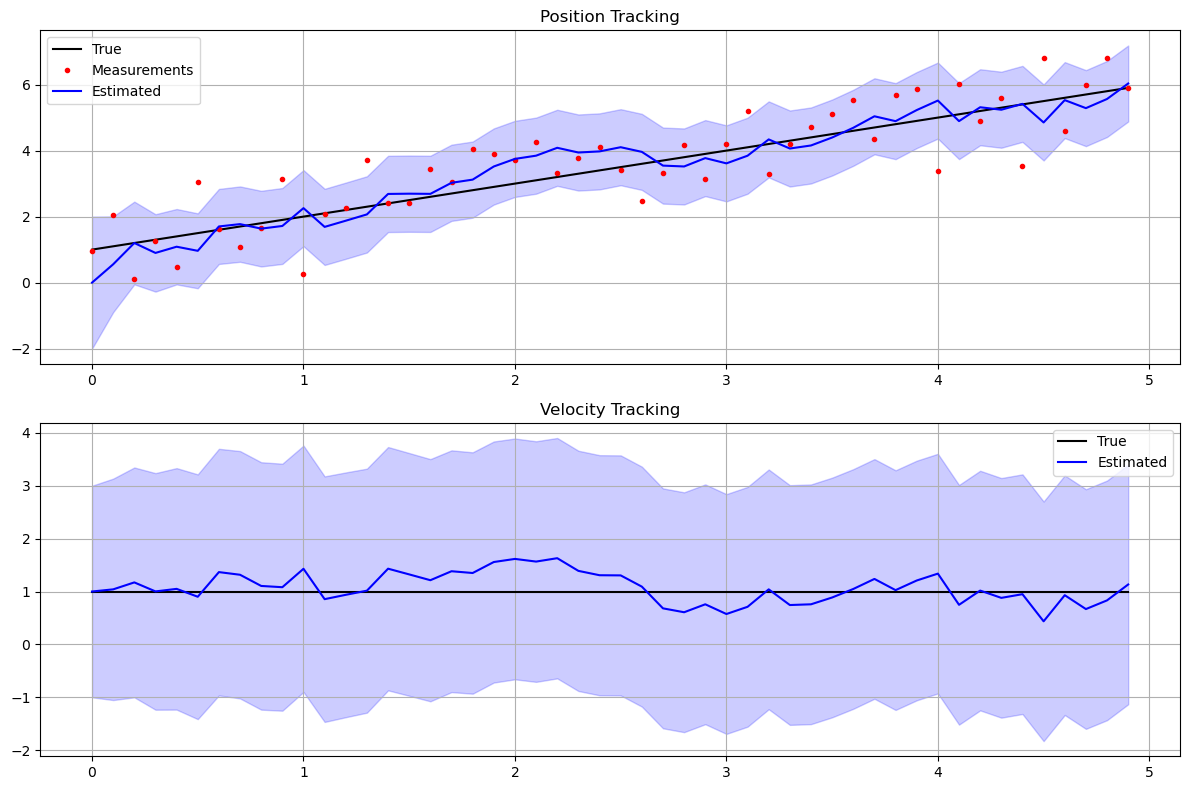

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter_1d(x0, P0, F, B, H, Q, R, u_seq, z_seq):
    """
    Implements Kalman Filter for a 1D system
    
    Args:
        x0: Initial state estimate
        P0: Initial state covariance 
        F: State transition matrix
        B: Control input matrix
        H: Measurement matrix
        Q: Process noise covariance
        R: Measurement noise covariance
        u_seq: Sequence of control inputs
        z_seq: Sequence of measurements
        
    Returns:
        x_hist: History of state estimates
        P_hist: History of state covariances
    """
    # Ensure x is a column vector
    x = x0.reshape(-1, 1)  #初始化状态变量
    P = P0    #定义状态变量初始协方差
    n_states = x.shape[0]   #状态维度
    
    # Pre-allocate arrays with correct shapes
    n_steps = len(u_seq) + 1   #步数为控制序列长度 + 1
    x_hist = np.zeros((n_steps, n_states))  #初始化状态估计（均值）历史
    P_hist = np.zeros((n_steps, n_states, n_states))  #初始化状态协方差历史
    
    # Store initial state and covariance
    x_hist[0] = x.flatten()   #初始状态向量化存入历史
    P_hist[0] = P  #存初始协方差
    
    for t, (u, z) in enumerate(zip(u_seq, z_seq)):
        # Reshape u and z to column vectors
        u = np.array([[u]])   #把标量包装成1*1二维数组
        z = np.array([[z]])
        
        # Prediction step
        x_pred = F @ x + B @ u   #预测步得先验均值 xk|k-1
        P_pred = F @ P @ F.T + Q   #预测步的先验协方差 Pk|k-1
        
        # Update step
        S = H @ P_pred @ H.T + R   #观测阶段得观测协方差S
        K = P_pred @ H.T @ np.linalg.inv(S)  #条件高斯 xk|k-1  |  z_t得到卡尔曼增益
        x = x_pred + K @ (z - H @ x_pred)  #计算后验均值 xk|k :注意这里H * xk|k-1 = zk|k-1为观测值的先验
        P = (np.eye(n_states) - K @ H) @ P_pred  #计算后验协方差 Pk|k
        
        # Store results
        x_hist[t + 1] = x.flatten()  #存入历史
        P_hist[t + 1] = P
    
    return x_hist, P_hist

# Example: Tracking constant-velocity target with noisy position measurements
dt = 0.1  # Time step

# System matrices
F = np.array([[1, dt],   # State transition matrix  x' = x + v * dt   
              [0, 1]])
B = np.array([[0.5*dt**2],  # Control input matrix  x和v额外的变化，由加速度a提供
              [dt]])
H = np.array([[1, 0]])   # Measurement matrix (measuring only position)  #仅仅观测位移

# Noise covariances
Q = np.array([[0.1, 0],  # Process noise  0.1方差过程噪声
              [0, 0.1]])
R = np.array([[1]])      # Measurement noise  1方差观测噪声

# Initial conditions
x0 = np.array([[0],    # Initial position   位置0
               [1]])    # Initial velocity  速度1
P0 = np.array([[1, 0],  # Initial state covariance  初始状态方差1
               [0, 1]])

# Generate some example data
n_steps = 50   #50步
t = np.arange(n_steps) * dt   #离散时间向量

# True trajectory (constant velocity)
true_x = x0[1,0] + x0[1,0] * t     #实际位移：50次迭代
true_v = np.ones_like(t) * x0[1,0]    #实际速度

# Control inputs (zero acceleration)
u = np.zeros((n_steps,1))     #没有加速度，所以是匀速，这里用不到B(有加速度不好计算truth来对比)

# Noisy measurements
z = true_x + np.random.normal(0, np.sqrt(R[0,0]), n_steps)  #噪声观测

# Run Kalman filter
x_hist, P_hist = kalman_filter_1d(x0, P0, F, B, H, Q, R, u, z.reshape(-1,1))  #得到卡尔曼滤波的估计序列

# Plot results
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(t, true_x, 'k-', label='True')
plt.plot(t, z, 'r.', label='Measurements')
plt.plot(t, x_hist[:-1,0], 'b-', label='Estimated')
plt.fill_between(t, 
                x_hist[:-1,0].flatten() - 2*np.sqrt(P_hist[:-1,0,0]),
                x_hist[:-1,0].flatten() + 2*np.sqrt(P_hist[:-1,0,0]),
                color='b', alpha=0.2)
plt.legend()
plt.title('Position Tracking')
plt.grid(True)

plt.subplot(212)
plt.plot(t, true_v, 'k-', label='True')
plt.plot(t, x_hist[:-1,1], 'b-', label='Estimated')
plt.fill_between(t,
                x_hist[:-1,1].flatten() - 2*np.sqrt(P_hist[:-1,1,1]),
                x_hist[:-1,1].flatten() + 2*np.sqrt(P_hist[:-1,1,1]),
                color='b', alpha=0.2)
plt.legend()
plt.title('Velocity Tracking')
plt.grid(True)

plt.tight_layout()
plt.show()

#缺点：高斯，线性，需要准确的Q和R，初始条件敏感


# Discussion of Kalman Filter Strengths and Limitations

## Strengths:
- Optimal state estimation for linear systems with Gaussian noise
- Handles both process and measurement uncertainty in a principled way
- Computationally efficient and recursive (no need to store history)
- Provides uncertainty estimates along with state estimates
- Works well for real-time applications
- Can incorporate control inputs and system dynamics

## Limitations:
- Assumes linear system dynamics and measurement models
- Assumes Gaussian noise distributions
- Performance depends heavily on accurate noise covariance matrices (Q and R)
- May diverge if system model is significantly incorrect
- Not suitable for highly nonlinear systems (would need Extended or Unscented KF)
- Can be sensitive to initial conditions (x0 and P0)

## When to Use:
- When the system is linear and the noise is Gaussian
- When real-time performance is critical and history storage is not feasible
- When accurate noise covariance matrices are available
- When the system dynamics are well-understood and predictable



# 3. Extended Kalman Filter Mathematical Formulation

The Extended Kalman Filter (EKF) extends the linear KF to nonlinear systems by linearizing around the current state estimate.

For a nonlinear system:
- x[k+1] = f(x[k], u[k]) + w[k]    # Process model
- z[k] = h(x[k]) + v[k]            # Measurement model

where:
- f(·) is the nonlinear state transition function
- h(·) is the nonlinear measurement function
- w[k] ~ N(0,Q) is process noise
- v[k] ~ N(0,R) is measurement noise

The EKF algorithm:

1. Prediction Step:
   - x̂[k|k-1] = f(x̂[k-1|k-1], u[k-1])
   - P[k|k-1] = F[k]P[k-1|k-1]F[k]ᵀ + Q

   where F[k] = ∂f/∂x evaluated at x̂[k-1|k-1]

2. Update Step:
   - K[k] = P[k|k-1]H[k]ᵀ(H[k]P[k|k-1]H[k]ᵀ + R)⁻¹
   - x̂[k|k] = x̂[k|k-1] + K[k](z[k] - h(x̂[k|k-1]))
   - P[k|k] = (I - K[k]H[k])P[k|k-1]

   where H[k] = ∂h/∂x evaluated at x̂[k|k-1]


# Problem Statement:
### Given:
- A nonlinear system with state x following dynamics: x[k+1] = x[k] + sin(x[k])*dt + u[k]*dt
- Nonlinear measurements of the form: z[k] = x[k]^2
- Control inputs u[k] (array of control values)
- Initial state estimate x0 and covariance P0 
- Process noise covariance Q (scalar)
- Measurement noise covariance R (scalar)
- Time step dt (scalar)
- Array of noisy measurements z_measurements

### Wanted:
- Estimate the true state x[k] at each time step k using the Extended Kalman Filter
- Track the state estimation error covariance P[k]

### Models Used:
- State transition model f(x,u) = x + sin(x)*dt + u*dt 
- Measurement model h(x) = x^2
- Jacobian of f(x,u): F = 1 + cos(x)*dt
- Jacobian of h(x): H = 2x

The following code implements the EKF for this nonlinear system and visualizes the results.



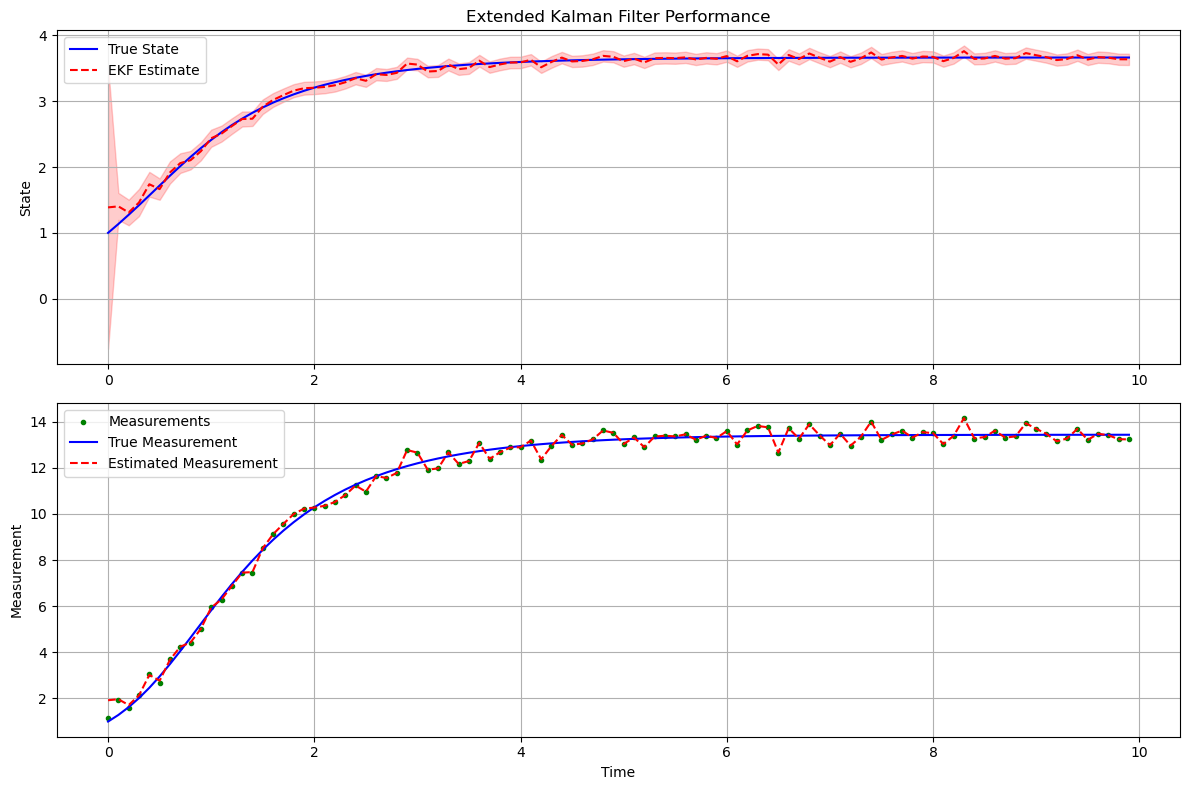

In [9]:
#这是一个加性噪声模型，如果是乘性噪声，需要给求非线性函数对噪声的导数
#这里只需要求两个雅可比（导数）：F和H
import numpy as np
import matplotlib.pyplot as plt

# Nonlinear system simulation
def nonlinear_system(x, u, dt):
    """Nonlinear state transition function"""
    # Simple nonlinear system: x[k+1] = x[k] + sin(x[k])*dt + u[k]*dt
    return x + np.sin(x)*dt + u*dt     # 非线性状态方程表达式

def measurement_function(x):
    """Nonlinear measurement function"""
    # Simple nonlinear measurement: z[k] = x[k]^2
    return x**2   #非线性观测方程表达式

def jacobian_F(x, dt):
    """Jacobian of state transition function"""
    return 1 + np.cos(x)*dt   #计算状态方程导数

def jacobian_H(x):
    """Jacobian of measurement function"""
    return 2*x    #计算观测方程表达式

# EKF Implementation
def extended_kalman_filter(z_measurements, u_inputs, dt, x0, P0, Q, R):
    """
    Extended Kalman Filter implementation
    
    Args:
        z_measurements: Array of measurements
        u_inputs: Array of control inputs
        dt: Time step
        x0: Initial state estimate
        P0: Initial error covariance
        Q: Process noise covariance
        R: Measurement noise covariance
    """
    # Initialize state estimates and covariances
    x_estimates = np.zeros(len(z_measurements))   #零初始化
    P_estimates = np.zeros(len(z_measurements))   #零初始化
    
    x_pred = x0   #初始化均值
    P_pred = P0   #初始化协方差
    
    for k in range(len(z_measurements)):
        # Prediction Step
        x_pred = nonlinear_system(x_pred, u_inputs[k], dt)  #求xk|k-1
        F = jacobian_F(x_pred, dt)   #求雅可比F
        P_pred = F * P_pred * F + Q  #求Pk|k-1
        
        # Update Step
        H = jacobian_H(x_pred)   #求雅可比H
        K = P_pred * H / (H * P_pred * H + R)   #求K
        
        z_pred = measurement_function(x_pred)  #求zk|k-1
        x_pred = x_pred + K * (z_measurements[k] - z_pred)   #求xk|k
        P_pred = (1 - K * H) * P_pred  #求Pk|k
        
        x_estimates[k] = x_pred   #存入历史
        P_estimates[k] = P_pred   #存入历史
        
    return x_estimates, P_estimates

# Simulation parameters
dt = 0.1  #时间间隔
t = np.arange(0, 10, dt)  #时间向量
n_steps = len(t)   #步数

# True system simulation
x_true = np.zeros(n_steps)  
x_true[0] = 1.0  # Initial state  初始状态

# Control inputs
u = 0.5 * np.ones(n_steps)  #全0.5的输入

# Generate true trajectory
for k in range(1, n_steps):
    x_true[k] = nonlinear_system(x_true[k-1], u[k-1], dt)  #计算系统迭代的实际轨迹

# Generate noisy measurements
R = 0.1  # Measurement noise covariance
z = measurement_function(x_true) + np.random.normal(0, np.sqrt(R), n_steps)  #得到观测

# EKF parameters
x0 = 0.0  # Initial state estimate
P0 = 1.0  # Initial error covariance
Q = 0.1   # Process noise covariance

# Run EKF
x_estimated, P_estimated = extended_kalman_filter(z, u, dt, x0, P0, Q, R)  
#根据观测、输入和初始状态反推估计轨迹

# Plotting
plt.figure(figsize=(12, 8))

# True state and estimates
plt.subplot(2, 1, 1)
plt.plot(t, x_true, 'b-', label='True State')
plt.plot(t, x_estimated, 'r--', label='EKF Estimate')
plt.fill_between(t, 
                x_estimated - 2*np.sqrt(P_estimated),
                x_estimated + 2*np.sqrt(P_estimated),
                color='r', alpha=0.2)
plt.grid(True)
plt.legend()
plt.title('Extended Kalman Filter Performance')
plt.ylabel('State')

# Measurements
plt.subplot(2, 1, 2)
plt.plot(t, z, 'g.', label='Measurements')
plt.plot(t, measurement_function(x_true), 'b-', label='True Measurement')
plt.plot(t, measurement_function(x_estimated), 'r--', label='Estimated Measurement')
plt.grid(True)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Measurement')

plt.tight_layout()
plt.show()


# Discussion of EKF Strengths and Limitations

## Strengths:
- Computationally efficient compared to other nonlinear filters
- Works well for mildly nonlinear systems
- Provides uncertainty estimates through covariance matrix
- Widely used and well-understood in practice

## Limitations:
- Relies on linearization which can introduce errors for highly nonlinear systems
- Assumes Gaussian noise and may perform poorly with non-Gaussian distributions
- Can diverge if initial state estimate is far from true state
- Jacobian matrices must exist and be computable
- May fail when system has multiple modes or discontinuities

## When to Use:
- When the system is mildly nonlinear and the noise is Gaussian
- When real-time performance is critical and history storage is not feasible
- When accurate noise covariance matrices are available
- When the system dynamics are well-understood and predictable




# 4. Mathematical Formulation of Particle Filter for Robot Localization

## State Representation
- Each particle represents a possible robot pose: $x_t^{[i]} = (x, y, \theta)^{[i]}$
- Set of N particles: $\{x_t^{[i]}, w_t^{[i]}\}_{i=1}^N$ where $w_t^{[i]}$ is the importance weight

## Algorithm Steps:

1. **Prediction Step**:
   For each particle $i$:
   $x_t^{[i]} = f(x_{t-1}^{[i]}, u_t) + \epsilon_t$
   where:
   - $f(\cdot)$ is the motion model
   - $u_t$ is the control input
   - $\epsilon_t$ is motion noise

2. **Update Step**:
   For each particle $i$:
   $w_t^{[i]} = p(z_t|x_t^{[i]})w_{t-1}^{[i]}$
   where:
   - $p(z_t|x_t^{[i]})$ is measurement likelihood
   - $z_t$ is the sensor measurement

3. **Normalization**:
   $w_t^{[i]} = \frac{w_t^{[i]}}{\sum_{j=1}^N w_t^{[j]}}$

4. **Resampling**:
   - Draw N new particles with probability proportional to weights
   - Set all weights to $w_t^{[i]} = \frac{1}{N}$

## Belief Representation:
$bel(x_t) \approx \sum_{i=1}^N w_t^{[i]}\delta(x_t - x_t^{[i]})$
where $\delta(\cdot)$ is the Dirac delta function

## Advantages for Global Localization:
- Can represent multi-modal distributions
- No linearization required
- Handles non-Gaussian noise
- Naturally represents uncertainty through particle spread



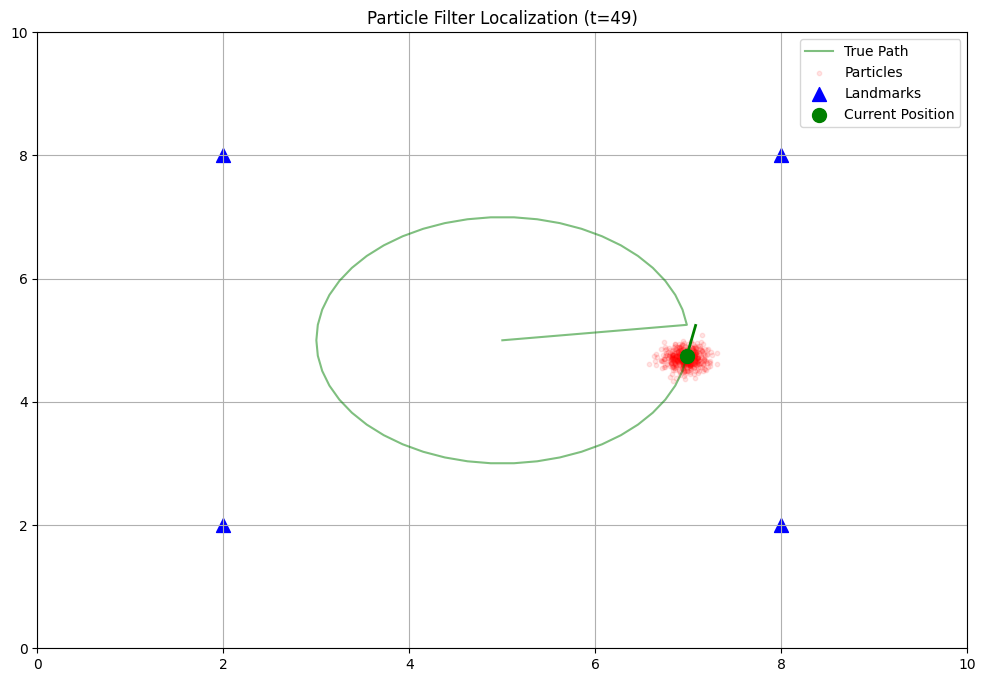

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
import math

class ParticleFilter:
    def __init__(self, num_particles=100, world_size=(10,10)):
        self.num_particles = num_particles
        self.world_size = world_size
        
        # Initialize particles randomly across the space
        self.particles = np.zeros((num_particles, 3))  # x, y, theta   初始化二维粒子map
        self.particles[:,0] = np.random.uniform(0, world_size[0], num_particles)  #x坐标
        self.particles[:,1] = np.random.uniform(0, world_size[1], num_particles)  #y坐标
        self.particles[:,2] = np.random.uniform(-np.pi, np.pi, num_particles)     #theta
        
        self.weights = np.ones(num_particles) / num_particles  #均匀分布的初始化权重
        
        # Store particle history for animation
        self.particle_history = [self.particles.copy()]  #历史

    def motion_update(self, u, noise_std=(0.1, 0.1, 0.05)):   #预测步
        """
        Motion model: Apply control input with noise
        u: (dx, dy, dtheta) control input
        """
        self.particles[:,0] += u[0] + np.random.normal(0, noise_std[0], self.num_particles)  #状态方程更新，从xt-1到xt，注意这里是+=
        self.particles[:,1] += u[1] + np.random.normal(0, noise_std[1], self.num_particles)
        self.particles[:,2] += u[2] + np.random.normal(0, noise_std[2], self.num_particles)
        
        # Normalize angles
        self.particles[:,2] = np.mod(self.particles[:,2] + np.pi, 2*np.pi) - np.pi  #标准化角度值，约束到-pi到pi的区间内
        
        # Store current particles
        self.particle_history.append(self.particles.copy())  #存储当前粒子

    def measurement_update(self, z, landmarks, noise_std=0.1):
        """
        Update weights based on measurement likelihood
        z: list of measured distances to landmarks
        landmarks: list of landmark positions (x,y)
        """
        for i in range(self.num_particles):
            likelihood = 1.0   #似然p(zt|xt)初始化为1
            for j, landmark in enumerate(landmarks):
                dx = self.particles[i,0] - landmark[0]   #这里的观测 z 是：到多个 landmarks 的距离
                dy = self.particles[i,1] - landmark[1]   
                expected_dist = np.sqrt(dx**2 + dy**2)  #期望距离
                
                error = z[j] - expected_dist  #实际距离和期望距离就是误差，我们有j个位置的landmark，对应观测zj，这对应j个误差
                likelihood *= np.exp(-error**2 / (2*noise_std**2))   #似然是由误差距离决定的高斯密度值
                #每经过一个样本，就乘一次，这是一个联合密度p(zt1|x1) * p(zt2|x1) * p(zt2|x1) *...
            
            self.weights[i] *= likelihood  #这里的权重是基于一堆landmark和一个唯一的xt给出的

        # Normalize weights
        self.weights /= np.sum(self.weights)

    def resample(self):
        """
        Resample particles based on weights
        """
        cumsum = np.cumsum(self.weights)      #这是一个累加和:cumsum[k] = w0 + w1 + ... + wk
        cumsum[-1] = 1.0  # Handle numerical errors 最后一个累加和确定为1，避免数值误差
        
        indices = []
        for _ in range(self.num_particles):   #抽num次，这就是新的粒子集合
            indices.append(np.searchsorted(cumsum, np.random.random()))    
            #np.searchsorted(cumsum, r) 找到第一个满足 cumsum[j] >= r 的索引 j ,等价于按权重抽中第 j 个粒子
            
        self.particles = self.particles[indices]   
        self.weights = np.ones(self.num_particles) / self.num_particles    #新的粒子集合拥有均等的权重

# Set up simulation parameters
np.random.seed(42)
world_size = (10, 10)   #世界大小
landmarks = [(2,2), (2,8), (8,2), (8,8)]  #四个landmark
pf = ParticleFilter(num_particles=500, world_size=world_size)   #实例化粒子滤波函数

# Generate true robot trajectory
steps = 50
true_path = np.zeros((steps, 3))
true_path[0] = [5, 5, 0]  # Start at center

# Run simulation
for t in range(1, steps):
    # Generate circular path
    true_path[t,0] = 5 + 2*np.cos(2*np.pi*t/steps)   #实际x的位置
    true_path[t,1] = 5 + 2*np.sin(2*np.pi*t/steps)   #实际y的位置
    true_path[t,2] = np.arctan2(true_path[t,1]-true_path[t-1,1],   #实际的theta
                               true_path[t,0]-true_path[t-1,0])
    
    # Control input
    u = true_path[t] - true_path[t-1]  #输入为实际位置之差
    
    # Generate measurements
    z = []
    for lm in landmarks:
        dx = true_path[t,0] - lm[0]    
        dy = true_path[t,1] - lm[1]   #和landmark实际的距离
        z.append(np.sqrt(dx**2 + dy**2) + np.random.normal(0, 0.1))   #确定观测z的值
    
    # Update particle filter
    pf.motion_update(u)   #用u来更新状态
    pf.measurement_update(z, landmarks)  #根据z的值和landmark的实际位置更新权重
    pf.resample()  #重采样

# Create animation
fig, ax = plt.subplots(figsize=(12, 8))

def animate(t):
    ax.clear()
    
    # Plot complete true path
    ax.plot(true_path[:,0], true_path[:,1], 'g-', alpha=0.5, label='True Path')
    
    # Plot particle history with fading effect
    particles = pf.particle_history[t]
    ax.scatter(particles[:,0], particles[:,1], c='r', alpha=0.1, s=10, label='Particles')
    
    # Plot landmarks
    ax.scatter([l[0] for l in landmarks], [l[1] for l in landmarks], 
              c='b', marker='^', s=100, label='Landmarks')
    
    # Plot current position
    ax.scatter(true_path[t,0], true_path[t,1], c='g', s=100, label='Current Position')
    
    # Add robot heading indicator
    heading_len = 0.5
    heading_x = true_path[t,0] + heading_len * np.cos(true_path[t,2])
    heading_y = true_path[t,1] + heading_len * np.sin(true_path[t,2])
    ax.plot([true_path[t,0], heading_x], [true_path[t,1], heading_y], 'g-', linewidth=2)
    
    ax.set_xlim(0, world_size[0])
    ax.set_ylim(0, world_size[1])
    ax.grid(True)
    ax.legend()
    ax.set_title(f'Particle Filter Localization (t={t})')

# Create and save animation
anim = FuncAnimation(fig, animate, frames=steps, interval=100, repeat=True)
anim.save('particle_filter.gif', writer='pillow', fps=10)
plt.show()


## Discussion of Particle Filter Strengths and Limitations

## Strengths:
- Non-parametric: Can represent non-Gaussian and multimodal distributions
- Handles non-linear motion and measurement models well
- Easy to implement and understand conceptually
- Computationally efficient for low-dimensional problems
- Naturally handles global localization and kidnapped robot problems

## Limitations:
- Particle depletion: Can lose track if too few particles survive resampling
- Computational cost scales with number of particles needed
- Performance depends heavily on number of particles used
- May struggle in high-dimensional state spaces
- Random sampling can lead to inconsistent performance between runs
- Requires careful tuning of parameters (number of particles, noise models)

## When to Use:
- Robot localization and navigation in 2D/3D environments
- Object tracking with non-linear motion
- SLAM (Simultaneous Localization and Mapping) applications
- When dealing with multi-modal probability distributions
- When exact state estimation is not required
- In systems with reasonable computational resources for the state space dimension
